In [1]:
using PyPlot
using Random
using Statistics
import JSON: parsefile
import StatsBase
using Printf
using LsqFit

In [2]:
## Some functions to replicate smithing
plt.style.use("seaborn-dark-palette")
bins = collect(1:1:8)
function dosmith(inferno)
    procs = 1
    while rand() < inferno
        procs += 1
    end
    return procs
end

function stupidsmith(inf1, inf2)
    procs = 1
    while ( rand() < inf1 ) || ( rand() < inf2 )
        procs += 1
    end
    return procs
end

function stupidSmithSims(inf1, inf2)
    return [stupidsmith(inf1, inf2) for a in collect(1:10_000_000)]
end

function smithGold(count, inferno, timer)
    totalTime = 0
    while count > 0
        totalTime += timer
        count -= dosmith(inferno)
    end
    return totalTime
end

function smithSims(inferno)
    return [dosmith(inferno) for a in collect(1:10_000_000)]
end

function smithChi2(data, hypothesis)
    ## Data
    z = StatsBase.fit( StatsBase.Histogram, data, bins)
    zx, zy = (z.edges[1][2:end] + z.edges[1][1:end-1])/2.0 .- 0.5, z.weights
    #zy = zy ./ sum(zy)
    ## Function
    f = smithSims(hypothesis)
    h = StatsBase.fit( StatsBase.Histogram, f, bins)
    hx, hy = (h.edges[1][2:end] + h.edges[1][1:end-1])/2.0 .- 0.5, h.weights
    hy = hy ./ sum(hy) .* sum(zy)
    ## Chi2
    chi2 = (hy .- zy).^2 ./ hy ./ 2
    chi2[isnan.(chi2)] .= 0
    return sum( chi2 )
end

function maw(x, size)
    backwards = div(size, 2)
    forwards = isodd(size) ? div(size, 2) : div(size, 2) - 1
    len = length(x)
    y = similar(x)
    for n = 1:len
        lo = max(1, n - backwards)
        hi = min(len, n + forwards)
        y[n] = mean(x[lo:hi])
    end
    y
end

expectedTime(base, lvl, inferno, smelts) = (base)/(99+lvl)*100 * 0.8 * (1 - inferno) * smelts 
function analyzeData(datafiles; kwargs...)
    kwargs = Dict(kwargs)
    cx = get(kwargs, :cx, collect(0.30:0.001:0.45))
    lvl = get(kwargs, :lvl, 100)
    base = get(kwargs, :base, 6.0)
    inferno = get(kwargs, :inferno, 0.4)
    yscale = get(kwargs, :yscale, "linear")
    gap = get(kwargs, :gap, 500)
    
    fig = plt.figure(figsize=(8,6*4))
    #fig.suptitle(datafiles[1])
    ## Collect the data
    data = []
    times = []
    for df in datafiles
        pdata = parsefile(df)["data"]
        push!(data, pdata);
        push!(times, pdata[1])
    end
    data = vcat(data...)
    @show length(data)
    datacluster = []
    timecluster = []
    last = 0
    count = 1
    for d in data
        if (d - last) < gap ## Clustering
            count += 1
        else
            push!(datacluster, count)
            push!(timecluster, d)
            count = 1
        end
        last = d
    end
    datacluster = datacluster[2:end]
    timecluster = timecluster[2:end]
    h = StatsBase.fit( StatsBase.Histogram, datacluster, bins )
    hx, hy = (h.edges[1][2:end] + h.edges[1][1:end-1])/2.0.-0.5, h.weights
    
    smeltCounts = sum(datacluster)
    @show expTime = expectedTime(base, lvl, inferno, smeltCounts) ./3600
    @show expectedTime(base, lvl, inferno, 1)
    
    ## Best fit for inferno proc
    cy = [smithChi2(datacluster, a) for a in cx]
    cy = cy .- minimum(cy)
    best_cx = cx[(cy .== minimum(cy))][1]
    bandsX = cx[cy .< 0.5]
    lb = minimum(bandsX)
    rb = maximum(bandsX)
    σ = (rb - lb)/2
    μ = lb + σ
    fform = ((cx.-μ).^2 ./2 ./σ^2)
    
    # Fit quadratic
    model(x, p) = (x .- p[1]).^2/2/p[2].^2
    fit_range = (cy .< 5.0)
    test_μ = cx[cy .== minimum(cy)][1]
    test_σ = (test_μ - cx[fit_range][1])/5.0
    fit = curve_fit(model, cx[fit_range], cy[fit_range], [test_μ, test_σ])
    @show μ, σ = fit.param
    fform = ((cx.-μ).^2 ./2 ./σ^2)
    
    ax = fig.add_subplot(4, 1, 1)
    ax.plot(cx, cy, ".")
    ax.plot(cx, fform)
    ttitle = @sprintf("Inferno: %0.0f%%", inferno*100)
    ax.set_title(ttitle)
    ax.set_xlabel("Inferno")
    ax.set_ylabel("χ^2")
    ax.set_ylim(0, 10)
    
    ## Likelihood
    lratio = exp.(-cy)
    lratio = lratio ./ sum(lratio)
    bandsY = lratio[cy .< 0.5]
    fform = exp.(-(cx.-μ).^2 ./2 ./σ^2)
    ax = fig.add_subplot(4, 1, 2)
    ax.plot(cx, lratio)
    ax.plot(cx, fform ./sum(fform))
    ax.fill_between(bandsX, 0, bandsY, alpha=0.5)
    ax.set_xticks(collect(minimum(cx):0.01:maximum(cx)))
    #ax.set_xlim(0.3, 0.4)
    ax.set_ylim(bottom=0)
    ax.set_xlabel("Inferno")
    
    @show reject_forty = abs(0.4 - μ)/σ
    @show reject_thirty = abs(0.3 - μ)/σ
    
    ## Plot inferno proc multiplicity (with best fit)
    ftwo = smithSims(0.1)
    fsix = smithSims(0.3)
    #fseven = smithSims(0.35)
    feight = smithSims(0.40)
    fBest = smithSims(best_cx)
    #fStupid = stupidSmithSims(0.3, 0.1)
    bestLabel = @sprintf("%0.1f%% (best fit)",best_cx*100)
    ax = fig.add_subplot(4, 1, 3)
    ax.hist(ftwo,   bins=bins, histtype="step", label="10%", density=true, align="left")
    ax.hist(fsix,   bins=bins, histtype="step", label="30%", density=true, align="left")
    #ax.hist(fseven, bins=bins, histtype="step", label="35%", density=true, align="left")
    ax.hist(feight, bins=bins, histtype="step", label="40%", density=true, align="left")
    #ax.hist(fStupid, bins=bins, histtype="step", label="30% & 10%", density=true, align="left")
    ax.hist(fBest, bins=bins, histtype="step", label=bestLabel, density=true, align="left", linestyle="dashed" )
    #plt.hist(datacluster, bins=bins, histtype="step", label="data", density=true, align="left")
    ax.errorbar(hx, hy/sum(hy), yerr=sqrt.(hy)/sum(hy), xerr=0.3, ls="none", label="data", color="black")
    ax.set_xlabel("Smelting Multiplicity")
    ax.set_ylabel("Relative Probability")
    ax.set_xticks(bins)
    ax.set_yticks(collect(0:0.05:1))
    ax.grid()
    plt.yscale(yscale)
    ax.legend()
    # Time series variation?
    tc = ((timecluster.-timecluster[1])/3600000)
    @show dcMean = mean(datacluster)
    @show dcDev = std(datacluster) / sqrt(length(datacluster)-1)
    ax = fig.add_subplot(4, 1, 4)
    ax.plot(tc, maw(datacluster, 1), ".")
    ax.plot(tc, maw(datacluster, 1000), label="MAW")
    ax.axhline(mean(feight), color="black", linestyle="dashed", label="40%")
    #plt.axhline(mean(fBest), color="orange", linestyle="dashed", label=bestLabel)
    ax.axhline(dcMean, color="orange", linestyle="dashed", label=bestLabel)
    ax.fill_between(tc, dcMean + dcDev, dcMean - dcDev, alpha=0.5, color="orange")
    ax.axhline(mean(fsix), color="red", linestyle="dashed", label="30%")
    ax.axhline(mean(ftwo), color="pink", linestyle="dashed", label="10%")
    ax.axvline(expTime, color="black")
    ax.set_xlabel("hours")
    ax.set_ylabel("Moving-average multiplicity")
    ax.set_xlim(minimum(tc), maximum(tc))
    ax.set_ylim(1, 2)
    ax.set_xticks(collect(0:1.0:maximum(tc)))
    ax.grid()
    ax.legend()
    return data
end

# expTime(lvl) = (20.0)/(99+lvl)*100*0.8*1000

analyzeData (generic function with 1 method)

length(data) = 15218
expTime = expectedTime(base, lvl, inferno, smeltCounts) ./ 3600 = 18.69984639016897
expectedTime(base, lvl, inferno, 1) = 4.423963133640553
(μ, σ) = fit.param = [0.34763765946040415, 0.0038995782390663187]
reject_forty = abs(0.4 - μ) / σ = 13.427693286167548
reject_thirty = abs(0.3 - μ) / σ = 12.21610557346071


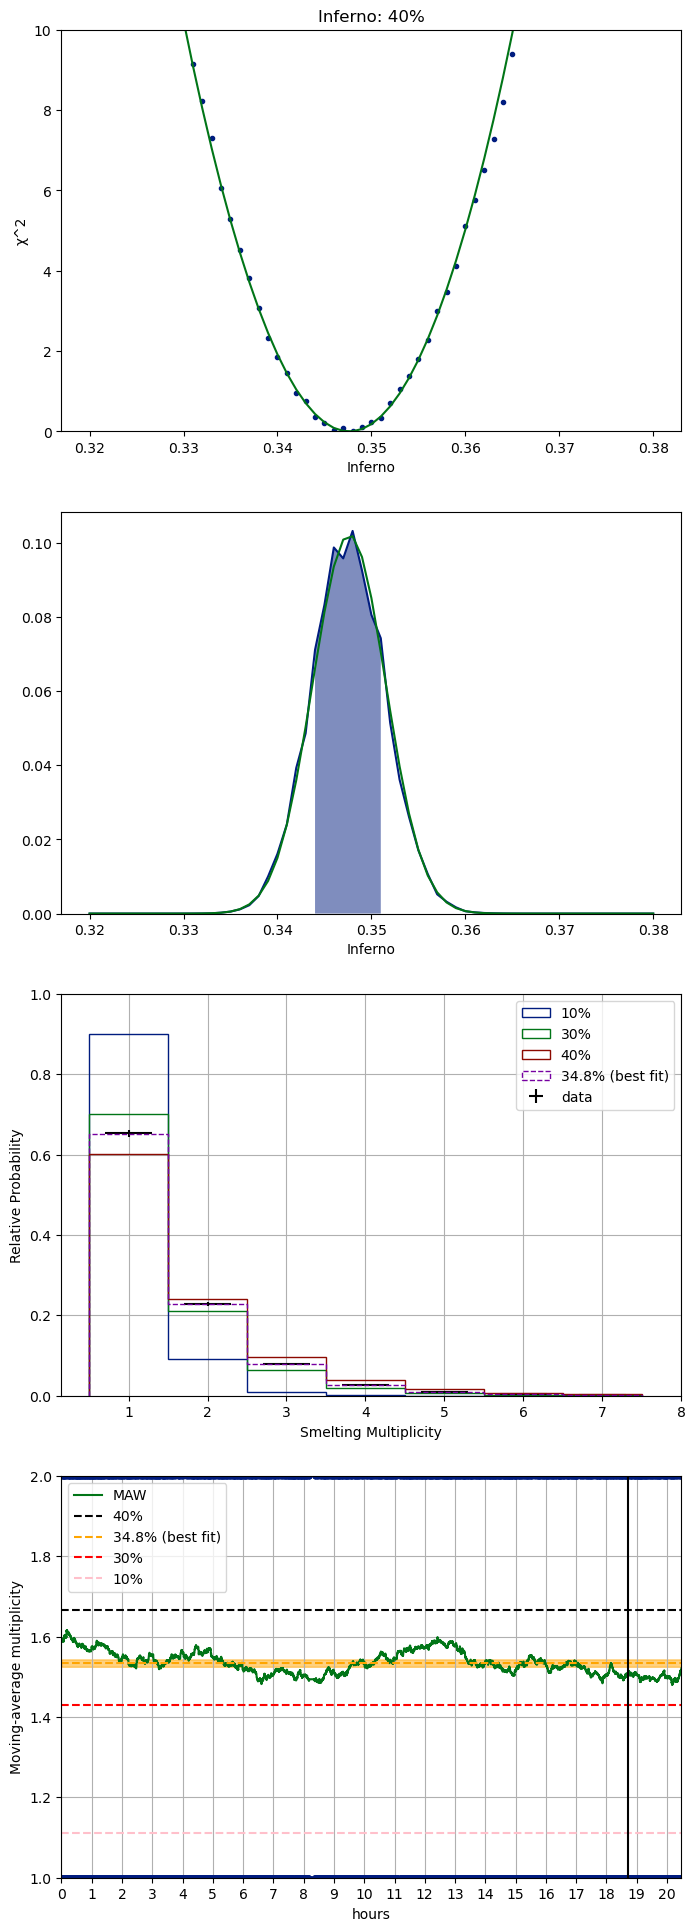

dcMean = mean(datacluster) = 1.5342811050615044
dcDev = std(datacluster) / sqrt(length(datacluster) - 1) = 0.009147775534955415


In [3]:
# Ironman data, inferno 6 boots + inferno food
d = analyzeData(["inferno_IM35_1.json", "inferno_IM35_2.json", "inferno_IM35_3.json"], cx=collect(0.32:0.001:0.38), lvl=118, 
    inferno=0.40, base=20.0);

length(data) = 5000
expTime = expectedTime(base, lvl, inferno, smeltCounts) ./ 3600 = 1.715
expectedTime(base, lvl, inferno, 1) = 1.2352941176470589
(μ, σ) = fit.param = [0.26421905187189826, 0.006227183145726489]
reject_forty = abs(0.4 - μ) / σ = 21.804553511692323
reject_thirty = abs(0.3 - μ) / σ = 5.745928342039694


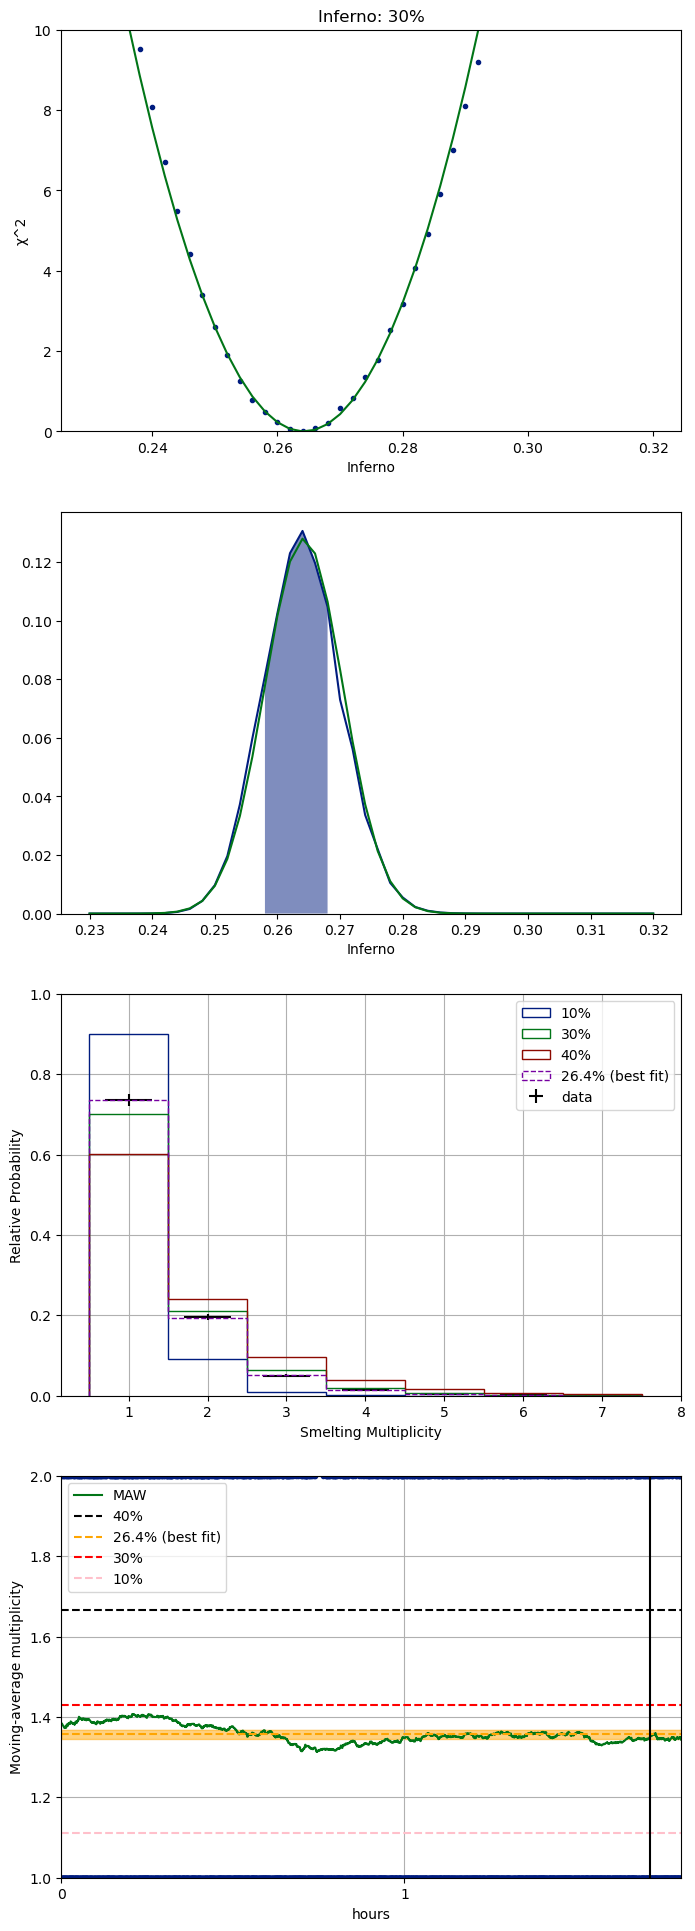

dcMean = mean(datacluster) = 1.3566775244299674
dcDev = std(datacluster) / sqrt(length(datacluster) - 1) = 0.011395099487240113


In [4]:
## Main data; Inferno boots 6, no food, was also careful to smelt exactly 5000 bars, so we can see if any
## messages were dropped / missed. Level: 173
analyzeData(["inferno_30.json"]; cx=collect(0.23:0.002:0.32), lvl=173, inferno=0.30);

length(data) = 5000
expTime = expectedTime(base, lvl, inferno, smeltCounts) ./ 3600 = 1.47
expectedTime(base, lvl, inferno, 1) = 1.0588235294117647
(μ, σ) = fit.param = [0.37430800486189914, 0.006871495487601992]
reject_forty = abs(0.4 - μ) / σ = 3.7389233805735724
reject_thirty = abs(0.3 - μ) / σ = 10.813949451901784


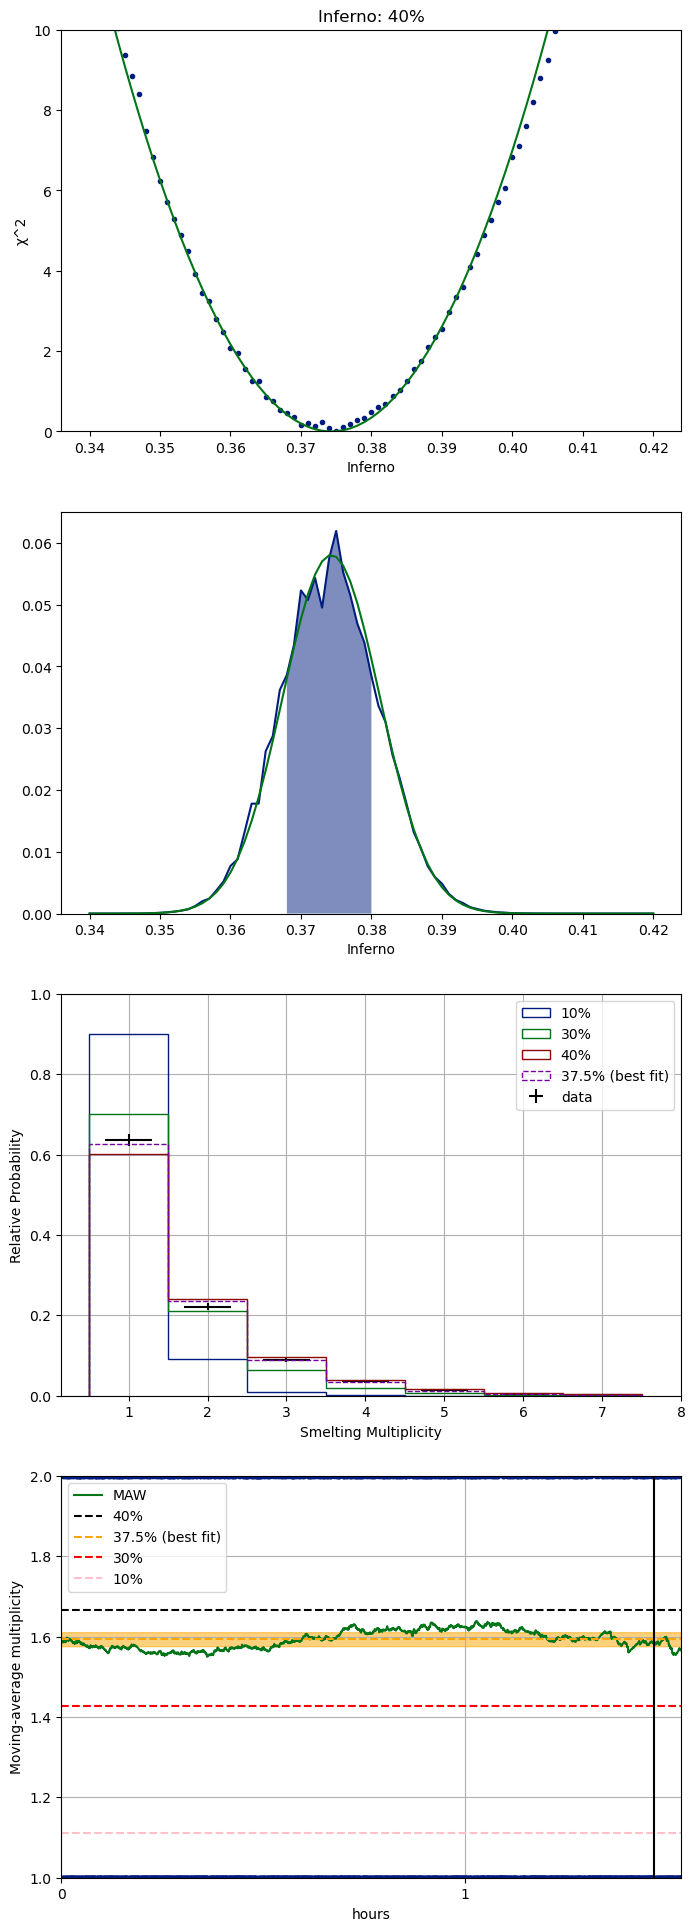

dcMean = mean(datacluster) = 1.59375
dcDev = std(datacluster) / sqrt(length(datacluster) - 1) = 0.01748994906692676


In [5]:
## Main data; Inferno boots 6, inferno food on bronze
analyzeData(["inferno_40.json"]; cx=collect(0.34:0.001:0.42), lvl=173, inferno=0.40);

length(data) = 5000
expTime = expectedTime(base, lvl, inferno, smeltCounts) ./ 3600 = 2.2054411764705883
expectedTime(base, lvl, inferno, 1) = 1.5882352941176472
(μ, σ) = fit.param = [0.048584681705461666, 0.0029428409023525503]
reject_forty = abs(0.4 - μ) / σ = 119.41363123423078
reject_thirty = abs(0.3 - μ) / σ = 85.43286118306743


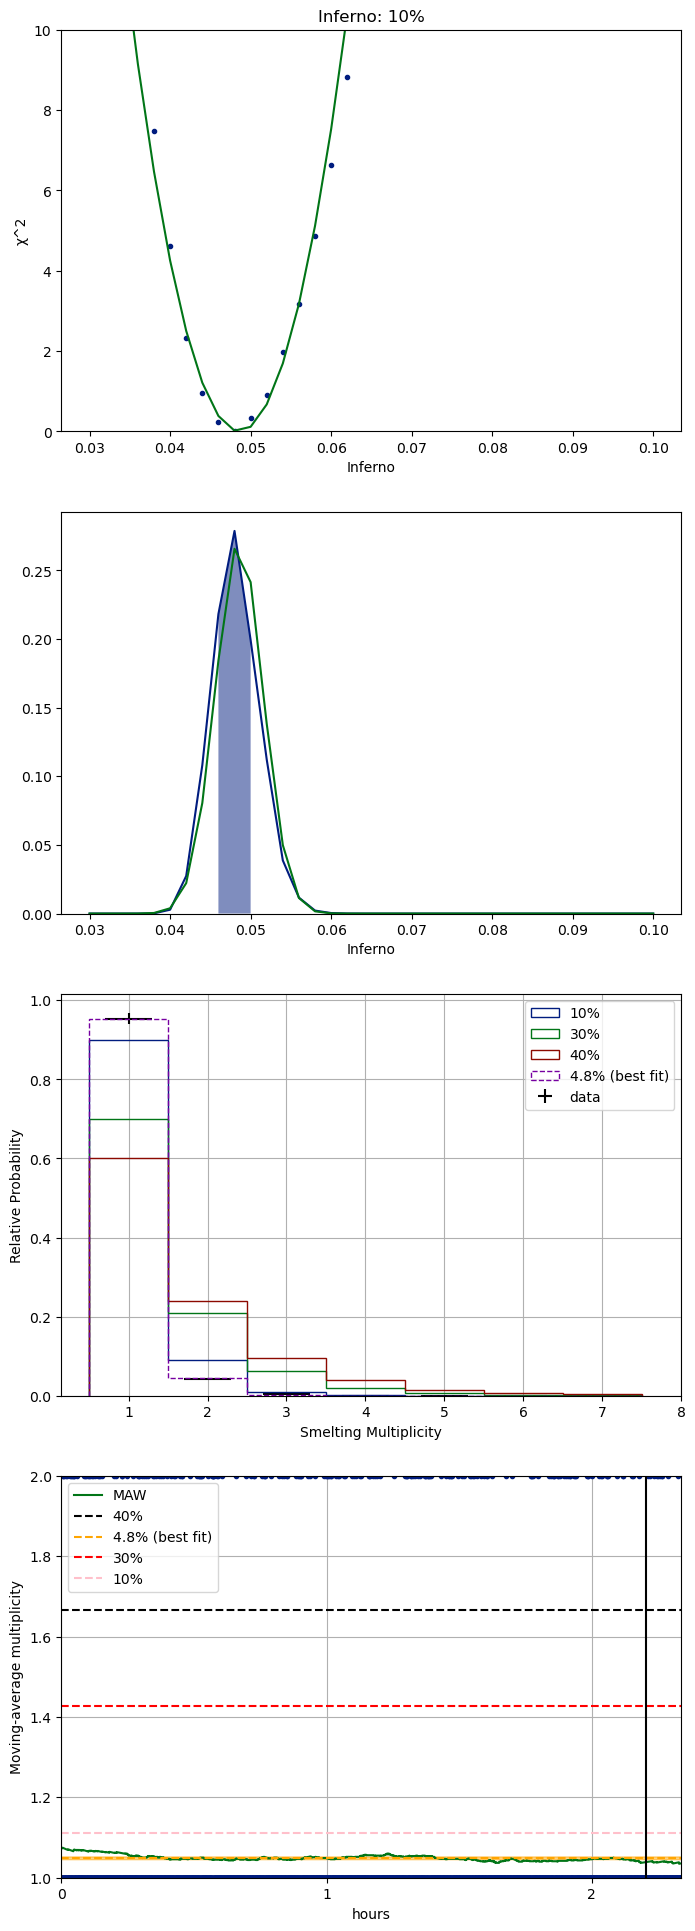

dcMean = mean(datacluster) = 1.0495486038211213
dcDev = std(datacluster) / sqrt(length(datacluster) - 1) = 0.003361943759154315


In [6]:
## Inferno 10
c = analyzeData(["inferno_10.json"]; cx=collect(0.03:0.002:0.10), lvl=173, inferno=0.10, gap=500);

length(data) = 888
expTime = expectedTime(base, lvl, inferno, smeltCounts) ./ 3600 = 0.4348039215686275
expectedTime(base, lvl, inferno, 1) = 1.7647058823529413
(μ, σ) = fit.param = [0.001, 0.0]
reject_forty = abs(0.4 - μ) / σ = Inf
reject_thirty = abs(0.3 - μ) / σ = Inf


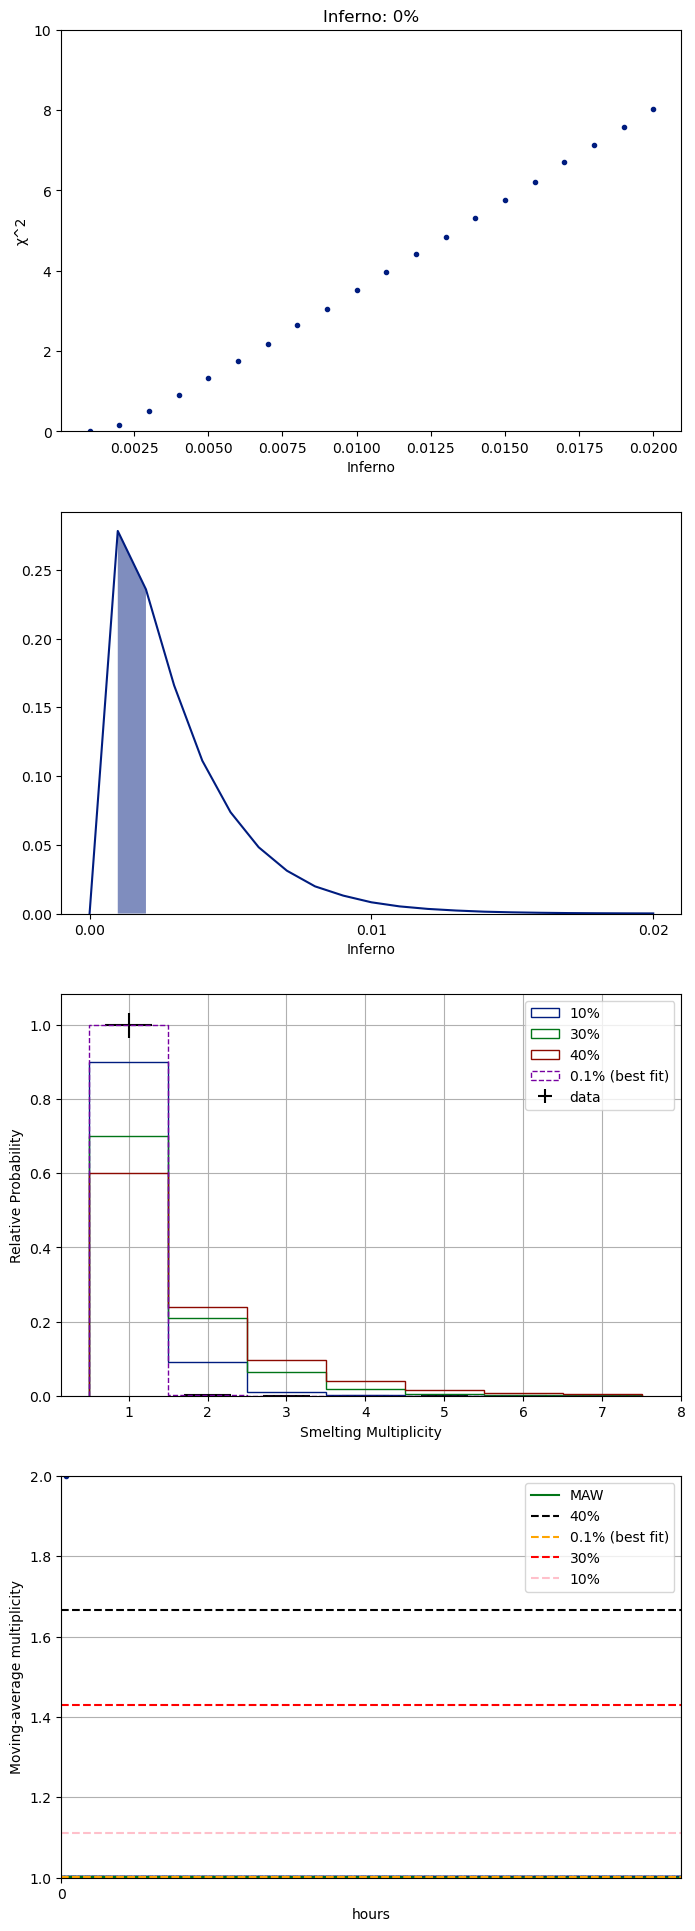

dcMean = mean(datacluster) = 1.0011286681715577
dcDev = std(datacluster) / sqrt(length(datacluster) - 1) = 0.0011293056571613583


In [7]:
## Main data; inferno food only
analyzeData(["inferno_0.json"]; cx=collect(0.0:0.001:0.02), lvl=173, inferno=0.0);